In [1]:
import os
import pandas as pd
import time
import nltk
import re
import sys
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import pyplot as plt
from csv import reader 

# Load Data
Loads data from earnings calls .txt files taken from Seeking Alpha with a pro account. 

Creates a chronological list of dictionaries with entries: filepath, stock ticker, year, quarter, unedited text content, list of tokens, counter of word frequency.


In [2]:
#input: unedited earnings calls from .txt files (type string)
#output: uniformly lowercase string with some stop word/stop phrases removed (type string)
def pre_process(text):
    result = str.lower(text)
    result = re.sub(r"(good morning( everyone)*)", "", result)
    result = re.sub(r"(thank you)", "", result)
    result = re.sub(r"(thank(s)*)", "", result)
    return result

In [3]:
#input: string text
#output: ordered list of all words in text, Counter object (word -> count of that word map)
#of all word tokens in the earnings call
def find_and_count_tokens(text):
    word_pattern = re.compile("\w[\w\-\']*\w|\w")
    tokens = word_pattern.findall(text)
    counts = Counter(tokens)
    return tokens, counts

In [4]:
year_vec = [str(i) for i in range(2010,2021)]
quarter_vec = ['q1', 'q2', 'q3', 'q4']

In [7]:
#format txt documents into dictionaries => file_name, ticker, date, time, year, quarter, content, counter
call_list = []
for year in year_vec:
    for quarter in quarter_vec:
        fn = str('raw_data/kr/' + 'kr_' + year + "_" + quarter + '.txt')
        if os.path.isfile(fn):
            d = {}
            d["filepath"] = fn
            word_pattern = re.compile("/[a-z]*/")
            tik = str(word_pattern.findall(fn))
            tik = tik[3:-3]
            d["ticker"] = tik
            d["year"] = year
            d["quarter"] = quarter
            file = open(fn)
            text = file.read()
            pre_processed_text = pre_process(text)
            d["content"] = pre_processed_text
            tokens, counts = find_and_count_tokens(pre_processed_text)
            d["tokens"] = tokens
            d["counter"] = counts
            call_list.append(d)

In [8]:
x = len(call_list)
print("Number of earnings calls:", x)
test = call_list[0]
counter = test["counter"]
lst = test["tokens"]
print("Most common words in one call:", counter.most_common()[:10])

Number of earnings calls: 40
Most common words in one call: [('the', 564), ('to', 344), ('and', 331), ('we', 307), ('that', 289), ('of', 282), ('in', 266), ('a', 222), ('our', 194), ('you', 193)]


In [9]:
for call in call_list:
    counter = call["counter"]
    print(call["year"], call["quarter"], counter["buyback"])

2010 q3 3
2010 q4 1
2011 q1 0
2011 q2 0
2011 q3 2
2011 q4 3
2012 q1 2
2012 q2 0
2012 q3 2
2012 q4 4
2013 q1 0
2013 q2 0
2013 q3 0
2013 q4 2
2014 q1 8
2014 q2 1
2014 q3 1
2014 q4 5
2015 q1 0
2015 q2 1
2015 q3 0
2015 q4 2
2016 q1 4
2016 q2 0
2016 q3 0
2016 q4 2
2017 q1 0
2017 q2 1
2017 q3 1
2017 q4 0
2018 q1 1
2018 q2 0
2018 q3 0
2018 q4 0
2019 q1 0
2019 q2 1
2019 q3 0
2019 q4 0
2020 q1 0
2020 q2 0


# Load Sentiment Word Lists
Import sentiment weighted words into lists from the widely used financial term list: Loughran and McDonald (2018). Also load an CMU created asset from the NLTK library that is useful for later measuring syllable count in words.

Uncertain refers to words that carry ambiguity and lack absolute measure.

Litigious is a proxy for word complexity. 

In [10]:
def load_sentiment_list(fn):
    file = open(fn)
    content = file.read()
    content = content.lower()
    result = content.split("\n")
    return result

In [11]:
pos_list = load_sentiment_list("pos.csv")
neg_list = load_sentiment_list("neg.csv")
uncertain_list = load_sentiment_list("uncertain.csv")
litigious_list = load_sentiment_list("litigious.csv")

In [12]:
negation_list = ['no', 'not', 'none', 'neither', 'never', 'nobody']
punctuation_string = "!#$%&\'()*+,./:;<=>?@[\\]^_`{|}~"

In [13]:
print("Positive Examples:", pos_list[:10], "\n")
print("Negative Examples:", neg_list[:10], "\n")
print("Uncertain Examples:", uncertain_list[:10], "\n")
print("Litigious Examples:", litigious_list[:10])

Positive Examples: ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes', 'accomplishing', 'accomplishment', 'accomplishments'] 

Negative Examples: ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated', 'abdicates', 'abdicating', 'abdication'] 

Uncertain Examples: ['abeyance', 'abeyances', 'almost', 'alteration', 'alterations', 'ambiguities', 'ambiguity', 'ambiguous', 'anomalies', 'anomalous'] 

Litigious Examples: ['abovementioned', 'abrogate', 'abrogated', 'abrogates', 'abrogating', 'abrogation', 'abrogations', 'absolve', 'absolved', 'absolves']


In [14]:
#will be used later for measuring syllables
cmu_dict = nltk.corpus.cmudict.dict()

# Helper Functions
Define user-defined functions to make later analysis more readable.

In [15]:
#apply word weights to list of word counts, return score for input sentiment
#(pos, neg, uncertain, litigious)
#extra_words can act as Laplace Smoothing
def score_counts(d, word_sentiment_list, extra_words = 0):
    #accumulate weights in this variable
    score = 0
    #count total words in the passage
    counter = d["counter"]
    total_tokens = sum(counter.values())
    #check for empty files
    if total_tokens == 0:
        return 0
    
    #for each word look up its score
    for word in counter.keys():
        if word in word_sentiment_list:
            score += counter[word]
    
    #normalize score for document length
    return score / (total_tokens + extra_words)

In [16]:
#need to do pos with pos and neg with neg
#used for finding negation with positive sentiment words and then adding this to negative score
def score_counts_negative(d, pos, neg, extra_words = 0, num_before = 3):
    score = 0
    lst = d["tokens"]
    total_tokens = len(lst)
    if total_tokens == 0:
        return 0
    
    for i, word in enumerate(lst):
        if word in pos:
            preceding = lst[(i-num_before):i]
            found_negation = False
            k = 0
            while k < len(preceding) and found_negation == False:
                if preceding[k] in negation_list:
                    found_negation = True
                k+=1
            if found_negation:
                score += 1
        elif word in neg:
            score += 1
    return score / (total_tokens + extra_words)

In [17]:
#used for finding positive sentiment excluding words with negations preceding
def score_counts_positive(d, pos, extra_words = 0, num_before = 3):
    score = 0
    lst = d["tokens"]
    total_tokens = len(lst)
    if total_tokens == 0:
        return 0
    
    for i, word in enumerate(lst):
        if word in pos:
            preceding = lst[(i-num_before):i]
            found_negation = False
            k = 0
            while k < len(preceding) and found_negation == False:
                if preceding[k] in negation_list:
                    found_negation = True
                k+=1
            if not found_negation:
                score += 1
    return score / (total_tokens + extra_words)

In [18]:
#input, dictionary element
#average word length of document sentences
def calc_avg_words_per_sentence(d):
    sentence_list = nltk.sent_tokenize(d["content"])
    num_words = len(d["tokens"])
    total_number_sentences = len(sentence_list)
    return num_words/total_number_sentences

In [19]:
print("Average Words Per Sentence:", calc_avg_words_per_sentence(test))

Average Words Per Sentence: 21.420783645655877


In [20]:
#input, CMU's provided dictionary for finding syllables in words
#user-determined syllable count cutoff
#output, list of words satisfying syllable minimum
def create_polly_syllabic_word_list(syllable_dict, syllable_cutoff = 3):
    my_dictionary = {}
    for key in syllable_dict:
        tmp_count = [len(list(y for y in l if y[-1].isdigit())) for l in syllable_dict[key]]
        tmp_count = tmp_count[0]
        if tmp_count >= syllable_cutoff:
            my_dictionary[key] = tmp_count
    poly_keys = my_dictionary.keys()
    
    return poly_keys

In [21]:
poly_word_list = list(create_polly_syllabic_word_list(cmu_dict, 3))

In [22]:
print("Number of words with 3+ syllables:", len(poly_word_list))
print("Some Examples:", list(poly_word_list)[500:515])

Number of words with 3+ syllables: 50229
Some Examples: ['acrobatic', 'acrobatics', 'acrobats', 'acrolein', 'acronym', 'acronyms', 'acropolis', 'acrylic', 'acrylics', 'actava', "actava's", 'actavas', 'actigall', 'actinide', 'actinidia']


In [23]:
#write out poly syllable word list so do not need to do generation again
file = open('poly_word_list.txt', 'w')
for word in poly_word_list:
    file.write(word)
    file.write('\n')
file.close()

In [24]:
def calc_percent_poly_words(d, eligible):
    total_words = len(d["tokens"])
    score = 0
    toks_set = set(d["tokens"])
    eligible_set = set(eligible)
    intersection = list(toks_set.intersection(eligible_set))
    if len(intersection) == 0:
        return 0
    else:
        counter = d["counter"]
        for key in intersection:
            score += counter[key]
    return score/total_words

In [25]:
print("Percent of 3+ Syllable Words:", str(calc_percent_poly_words(test, poly_word_list)*100)[:5] + "%")


Percent of 3+ Syllable Words: 11.39%


# Main
This section adds more information to earnings call dictionaries: pos score, neg score, uncertain score, litigious score, average words per sentence, proportion of words with 3+ syllables, and gunning-fog index) 

In [26]:
for call in call_list:
    call["pos_score"] = score_counts_positive(call, pos_list) * 100
    call["neg_score"] = score_counts_negative(call, pos_list, neg_list) * 100
    call["uncertain_score"] = score_counts(call, uncertain_list) * 100
    call["lit_score"] = score_counts(call, litigious_list) * 100
    call["avg_words_per_sentence"] = calc_avg_words_per_sentence(call)
    call["poly_word_percent"] = calc_percent_poly_words(call, poly_word_list)
    call["fog_index"] = 0.4 * call["avg_words_per_sentence"] + 100 * call["poly_word_percent"]


In [27]:
for call in call_list[:10]:
    print(call["fog_index"])

19.96484598569992
21.452692267122373
19.24924529680603
19.40581145441856
19.659593678283372
20.20336193528378
19.61299045699238
19.374034281691866
18.812104845325713
20.044547306244745


# Visualize

In [28]:
#reads file to two lists
#dates holds ordered list of dates of earnings calls
#prices holds ordered list of closing stock prices on date of earnings calls
prices = []
dates = []
with open("relevant_kr_stock_prices.csv") as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        dates.append(row[0])
        prices.append(float(row[1]))
for i in range(10):
    print(str(dates[i]) + ":", str(prices[i])[:5])

12_02_10: 10.81
03_03_11: 11.51
06_16_11: 11.99
09_09_11: 11.01
12_01_11: 11.68
03_01_12: 12.22
06_14_12: 11.29
09_07_12: 11.36
11_29_12: 13.12
03_07_13: 15.12


In [29]:
fog_index = []
negativity = []
positivity = []
scaled_neg = []
scaled_pos = []
for call in call_list:
    fog_index.append(call["fog_index"])
    negativity.append(call["neg_score"])
    scaled_neg.append(call["neg_score"]*30)
    scaled_pos.append(call["pos_score"]*30)
    positivity.append(call["pos_score"])
print("Fog Index:", fog_index[:5])
print("Negativity:", negativity[:5])
print("Positivity:", positivity[:5])

Fog Index: [19.96484598569992, 21.452692267122373, 19.24924529680603, 19.40581145441856, 19.659593678283372]
Negativity: [1.0975027835215523, 0.8103557145864029, 0.8986766739087498, 0.7800157977883095, 0.753537952582246]
Positivity: [1.5110545570224272, 1.6417596295516732, 1.3727039304760025, 1.253949447077409, 1.4886969307112663]


In [30]:
def gen_delta(lst):
    i = 1
    result = [0]
    while i < len(lst):
        curr = lst[i]
        past = lst[i-1]
        delta = ((curr-past)/past)*100
        result.append(delta)
        i+=1
    return result

In [31]:
def gen_delta_full_year(lst):
    i = 4
    result = [0, 0, 0, 0]
    while i < len(lst):
        curr = lst[i]
        past = lst[i-1]
        delta = ((curr-past)/past)*100
        result.append(delta)
        i+=1
    return result

In [32]:
def gen_change_from_baseline(lst):
    avg = sum(lst)/len(lst)
    i = 0
    result = []
    while i < len(lst):
        curr = lst[i]
        percent_diff = ((curr-avg)/avg)*100
        result.append(percent_diff)
        i+=1
    return result

In [33]:
def gen_abs_change_from_avg(lst):
    avg = sum(lst)/len(lst)
    print(avg)
    i = 0
    result = []
    while i < len(lst):
        curr = lst[i]
        print(curr)
        diff = 1+(avg - curr)
        result.append(diff)
        i+=1
    return result

In [34]:
neg_delta_full_year = gen_delta_full_year(negativity)
neg_change_from_avg = gen_change_from_baseline(negativity)
neg_delta = gen_delta(negativity)
pos_delta = gen_delta(positivity)
fog_delta = gen_delta(fog_index)
price_delta = gen_delta(prices)[1:]
price_delta.append(0)
print(neg_change_from_avg)

#testing = gen_abs_change_from_avg(negativity)

[50.24946084201552, 10.93867918601253, 23.029925530420204, 6.785107815306649, 3.1602587249888097, 3.0785593522252492, 2.6727002078741307, -14.968191528152703, -5.206033998857867, -21.33572639796295, -1.231454993312981, -22.506269915180123, 38.41512709224559, 3.0532869637072144, 4.305685058799355, 14.977897857233168, 7.661833264153469, -3.6754887319794767, -5.041168167088079, -4.7880296594417215, -17.632051088162836, 9.130666692040734, 12.902538011196624, 17.207607775131674, 37.37343281497565, 22.14341334493865, 9.122201759630064, -4.356508281211464, -3.2347169547613763, -21.57418026671932, -18.11812539398226, -14.249162768760318, -3.507061845816306, -17.360635494774147, -20.390312060345888, -26.87857673485901, -32.866726342498794, -18.360371426063114, -0.6830140533827778, 1.755423810417956]


In [35]:
inverse_neg = []
for i in range(len(neg_change_from_avg)):
    inverse_neg.append(neg_change_from_avg[i] * -1)
inverse_neg_delta = []
for i in range(len(neg_delta)):
    inverse_neg_delta.append(neg_delta[i] * -1)

## Percent Change in Forward Stock Price vs. Percent Difference in Sentiment from Average

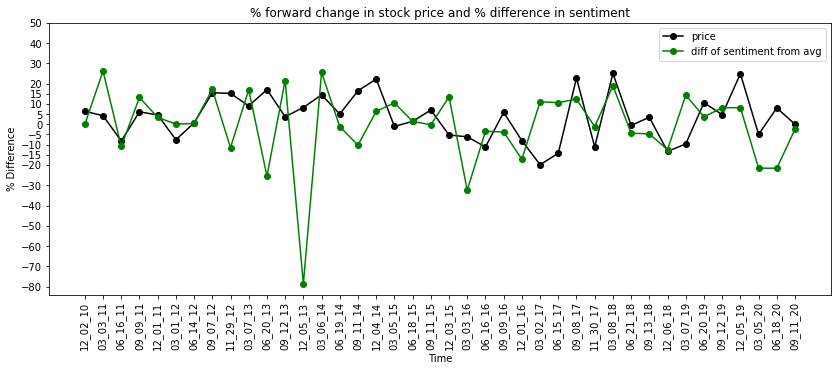

In [41]:
#percent change negativity vs. stock price

plt.figure(figsize=(14,5))
plt.ylabel("% Difference")
plt.xlabel("Time")
plt.plot(dates,price_delta, marker = 'o', c='black', label='price')
plt.plot(inverse_neg_delta, marker = 'o', c='green', label='diff of sentiment from avg')
plt.legend()
plt.xticks(rotation=90)
plt.yticks([-80,-70, -60,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50])
plt.title("% forward change in stock price and % difference in sentiment")
plt.show()

## Percent Change in Forward Stock Price vs. Percent Change in Sentiment From Previous Call

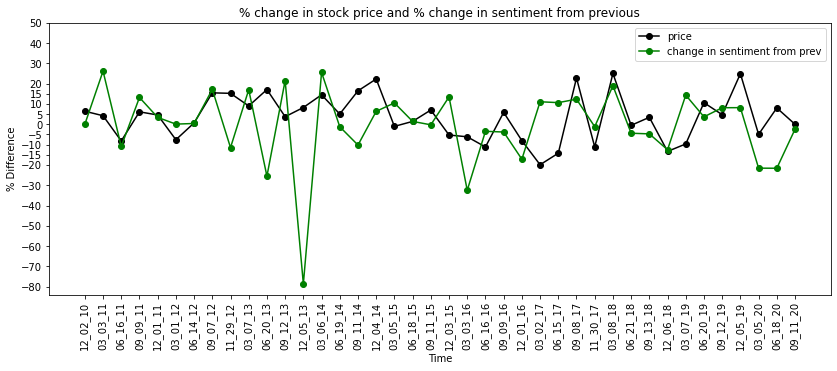

In [43]:
#percent change negativity vs. stock price

plt.figure(figsize=(14,5))
plt.ylabel("% Difference")
plt.xlabel("Time")
plt.plot(dates,price_delta, marker = 'o', c='black', label='price')
plt.plot(inverse_neg_delta, marker = 'o', c='green', label='change in sentiment from prev')
#plt.plot(inverse_neg, marker = 'o', c='green', label='sentiment')
#plt.plot(neg_change_from_avg, marker = 'o', c='green', label='test')
plt.legend()
plt.xticks(rotation=90)
plt.yticks([-80,-70, -60,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50])
plt.title("% change in stock price and % change in sentiment from previous")
plt.show()

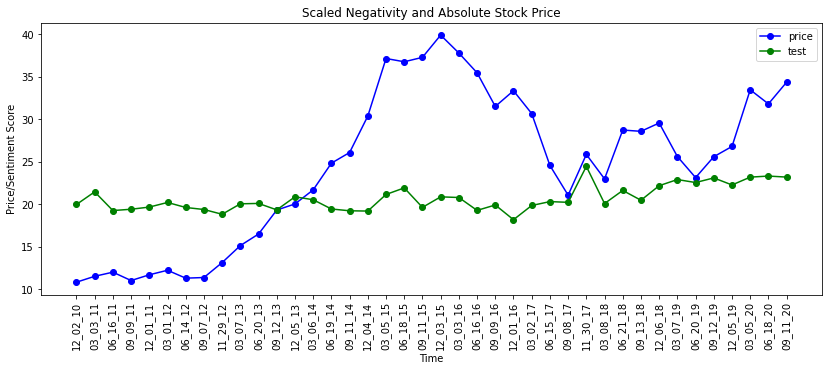

In [44]:
#absolute change negativity (scaled) vs. stock price
plt.figure(figsize=(14,5))
plt.ylabel("Price/Sentiment Score")
plt.xlabel("Time")
plt.plot(dates, prices, c='b', marker = 'o', label='price')
#plt.plot(scaled_neg, c='orange', marker = 'o', label='negative sentiment')
plt.plot(fog_index, c='green', marker = 'o', label='test')
plt.legend()
plt.xticks(rotation=90)
plt.title("Scaled Negativity and Absolute Stock Price")
plt.show()

# Automated Data Scraping

In [39]:
#these vectors are built above, don't be redundant
#year_vec = [str(i) for i in range(2010,2021)]
#quarter_vec = ['q1', 'q2', 'q3', 'q4']
months = {'January': '01', 'February': '02', 'March': '03', 'April': '04', 'May': '05', 'June': '06', 'July': '07', 'August': '08', 'September': '09', 'October': '10', 'November': '11', 'December': '12'}
date_format_lst = []
date_idx_lst = []
for year in year_vec:
    for quarter in quarter_vec:
        fn = "raw_data/kr/kr_" + year + "_" + quarter + ".txt"
        if os.path.isfile(fn):
            file = open(fn, 'r')
            line = file.readline()
            line = line.split()
            idx = line.index("Call")
            
            m = months[line[idx+1]]
            d = line[idx+2][:-1]
            if len(d) == 1:
                d = "0" + d
            y = line[idx+3]
            date_string = m + "_" + d + "_" + y[2:]
            date_idx = y + "-" + m + "-" + d
            date_idx_lst.append(date_idx)
            date_format_lst.append(date_string)
            
for i, _ in enumerate(date_format_lst[:5]):
    print(date_format_lst[i])
    print(date_idx_lst[i])
file.close()

12_02_10
2010-12-02
03_03_11
2011-03-03
06_16_11
2011-06-16
09_09_11
2011-09-09
12_01_11
2011-12-01


In [40]:
#with access to all closing prices of stock for last decade, 
#identify closing price on dates of earnings calls
#save to fn filepath
fn = "relevant_kr_stock_prices.csv"
file = open(fn,'w')
with open("historical_kr_stock_price.csv") as read_obj:
    csv_reader = reader(read_obj)
    i = 0
    for row in csv_reader:
        if row[0] == date_idx_lst[i]:
            date = date_format_lst[i]
            close_price = row[4]
            i+=1
            file.write(date + "," + close_price + '\n')
file.close()